## Start 

In [4]:
import sklearn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn.linear_model import RANSACRegressor
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split

In [6]:
#Backend """

plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')"""

NameError: name 'warnings' is not defined

In [80]:
df = pd.read_csv('train.csv')
df_copy = df.copy()

In [81]:
features = {
    'LandContour': ['Low', 'HLS', 'Bnk', 'Lvl'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSeWr', 'AllPub'],
    'LandSlope': ['Gtl', 'Mod', 'Sev'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Electrical': [np.nan,'Mix', 'FuseP','FuseF','FuseA', 'SBrkr'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'GarageQual':[np.nan,'Po','Fa','TA','Gd','Ex' ],
    'GarageCond':[np.nan,'Po','Fa','TA','Gd','Ex' ],
    'PoolQC':[np.nan,'Po','Fa','TA','Gd','Ex' ],
    'Fence':[np.nan,'MnWw','GdWo','MnPrv','GdPrv' ],
    'GarageFinish':[np.nan,'Unf','RFn','Fin'  ],
    'GarageType':[np.nan,'Detchd','CarPort','BuiltIn','Basment','Attchd','Types','2Types'], 
    'FireplaceQu':[np.nan,'Po','Fa','TA','Gd','Ex'  ],
    'BsmtQual':[np.nan,'Po','Fa','TA','Gd','Ex'  ],
    'BsmtCond':[np.nan,'Po','Fa','TA','Gd','Ex'  ],
    'BsmtExposure':[np.nan,'No','Mn','Av','Gd'],
    'BsmtFinType1':[np.nan,'Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'BsmtFinType2':[np.nan,'Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
    'HouseStyle':['SLvl','SFoyer','1Story','1.5Unf','1.5Fin','2Story','2.5Unf','2.5Fin'],
    'Functional':['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'] 
    
}

In [82]:
def ordinal_encoder(df, features={}):
    for column in features.keys():
        if column not in df.columns:
            continue
        for val in df[column].unique():
            if val not in features[column]:
                continue
            vals = features[column]
            df[column] = df[column].replace(val, vals.index(val) + 1)
    return df
df = ordinal_encoder(df,features)

In [83]:
# List of columns to be converted into dummy features
columns_to_dummify = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
                      'BldgType', 'CentralAir', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                      'Foundation', 'MiscFeature', 'SaleType', 'SaleCondition', 'MasVnrType', 'Heating']

# Create dummies and concatenate them to the original dataframe
df = pd.concat([df, pd.get_dummies(df[columns_to_dummify], prefix=columns_to_dummify)], axis=1)

# Drop the original columns
df.drop(columns_to_dummify, axis=1, inplace=True)


<Axes: xlabel='SalePrice', ylabel='Density'>

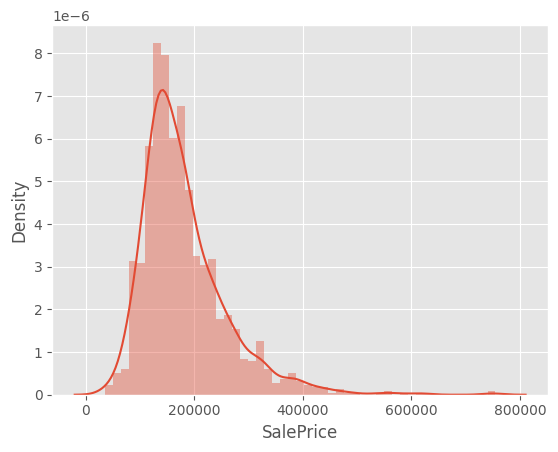

In [84]:
sn.distplot(df['SalePrice'])

In [85]:
corr_matrix = df.corr()

# Sort the correlations by their absolute values for 'Saleprice'
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).index[1:11]
df[top_corr_features]

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath
0,7,1710,4,4,2,548,856,856,5,2
1,6,1262,3,3,2,460,1262,1262,5,2
2,7,1786,4,4,2,608,920,920,5,2
3,7,1717,3,4,3,642,756,961,4,1
4,8,2198,4,4,3,836,1145,1145,5,2
...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,3,3,2,460,953,953,5,2
1456,6,2073,3,3,2,500,1542,2073,5,2
1457,7,2340,5,4,1,252,1152,1188,4,2
1458,5,1078,3,4,1,240,1078,1078,4,1


In [86]:
corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:11]

OverallQual   0.79
GrLivArea     0.71
ExterQual     0.68
KitchenQual   0.66
GarageCars    0.64
GarageArea    0.62
TotalBsmtSF   0.61
1stFlrSF      0.61
BsmtQual      0.59
FullBath      0.56
Name: SalePrice, dtype: float64

In [87]:
df[top_corr_features].describe()

,OverallQual,GrLivArea,ExterQual,KitchenQual,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,BsmtQual,FullBath
count,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,6.10,1515.46,3.40,3.51,1.77,472.98,1057.43,1162.63,4.49,1.57
std,1.38,525.48,0.57,0.66,0.75,213.80,438.71,386.59,0.88,0.55
min,1.00,334.00,2.00,2.00,0.00,0.00,0.00,334.00,1.00,0.00
25%,5.00,1129.50,3.00,3.00,1.00,334.50,795.75,882.00,4.00,1.00
50%,6.00,1464.00,3.00,3.00,2.00,480.00,991.50,1087.00,5.00,2.00
75%,7.00,1776.75,4.00,4.00,2.00,576.00,1298.25,1391.25,5.00,2.00
max,10.00,5642.00,5.00,5.00,4.00,1418.00,6110.00,4692.00,6.00,3.00


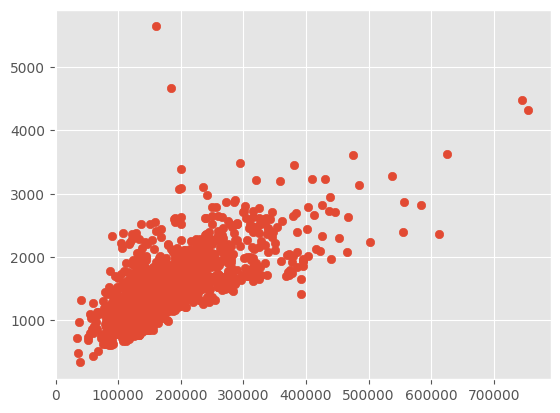

In [88]:
plt.scatter(df['SalePrice'], df['GrLivArea'])

In [89]:
def fillna(df):
    cols_with_nans = df.columns[df.isna().any()]
    for col in cols_with_nans:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

In [90]:
df = fillna(df)

In [91]:
df.isna().any()

Id              False
MSSubClass      False
LotFrontage     False
LotArea         False
LandContour     False
                ...  
Heating_GasA    False
Heating_GasW    False
Heating_Grav    False
Heating_OthW    False
Heating_Wall    False
Length: 210, dtype: bool

In [92]:
x = df.drop(columns=['SalePrice'])
y = df['SalePrice']

#### outlier treatment

In [93]:
# Assume X is your feature matrix and y is your target variable
# Choose a linear regression model for your data
model = RANSACRegressor(random_state=14)

# Fit the model to your data
model.fit(x, y)

# Predict the values for all data points
y_pred = model.predict(x)

# Calculate the residuals
residuals = np.abs(y - y_pred)

# Choose a threshold value for the residuals (e.g., 3 standard deviations)
threshold = np.std(residuals) * 3

# Identify outliers as data points whose residuals are above the threshold and get their indeces to clean y also
outliers = x[residuals > threshold]
outliers_indeces = list(outliers.index)




In [198]:
# Remove outliers from the dataset 
cleaned_y = y.drop(outliers_indeces, axis=0)
cleaned_x = x.drop(outliers_indeces, axis=0)


In [199]:
print(cleaned_y.shape)
print(cleaned_x.shape)
print((cleaned_x.dtypes=='object').any()) #-> no object cols

(1432,)
(1432, 209)
False


In [200]:
avg_sale_price = np.around(np.mean(cleaned_y))
avg_sale_price


176486.0

### Feature selection

In [132]:
cleaned_ds = pd.concat([cleaned_x,cleaned_y], axis=1)
cleaned_ds

In [286]:
#Using pearson correlation
pearson_corr = cleaned_ds.corr()

# Sort the correlations by their absolute values for 'Saleprice' and set corr threshold to 0.4 
top_corr_features = list(pearson_corr['SalePrice'].abs()[pearson_corr['SalePrice']>0.6].abs().sort_values(ascending=False).index[1:15])
top_corr_features


['OverallQual',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF']

# Modelling

### 1 variant - using previous Feature selection, find the 5 best models


In [287]:
top_x = cleaned_x[top_corr_features]
pearson_ds = pd.concat([top_x,cleaned_y],axis=1)
pearson_ds.name = 'pearson' #used later for RMSE columns!

### 2 variant - using sklearn feature_selection methods on 'cleaned_ds', find 5 best models

In [288]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.linear_model import LinearRegression

In [289]:
#1 SelectKBest + mutual info
selector = SelectKBest(score_func=mutual_info_regression, k=10)
mutual_x = pd.DataFrame(selector.fit_transform(cleaned_x, cleaned_y))


In [290]:
#2 RFECV - with cross-validation
# Create a custom scorer for negative RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

estimator = LinearRegression()
selector = RFECV(estimator,cv=5, step=1, scoring=negative_rmse_scorer)
rfecv_x = pd.DataFrame(selector.fit_transform(cleaned_x, cleaned_y))

### Prepare for multiple lazyPredict evaluations


In [291]:
#Here you can put any ds for evaluation. Don't forget to add name attribute
cleaned_ds = pd.concat([cleaned_x,cleaned_y],axis=1)
mutual_ds = pd.concat([mutual_x,cleaned_y], axis=1)
rfecv_ds = pd.concat([rfecv_x,cleaned_y],axis=1)
rfecv_ds.dropna(inplace=True)
mutual_ds.dropna(inplace=True)
cleaned_ds.name = 'clean'
mutual_ds.name = 'mutual'
rfecv_ds.name = 'rfecv'

### Evaluation of accuracy of three techniques

In [292]:
#Evaluate the three techniques
datasets = [cleaned_ds,pearson_ds,mutual_ds, rfecv_ds]
lazy = LazyRegressor(verbose=0 ,ignore_warnings = True, custom_metric=mean_squared_error)

for ds in datasets:
    x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(ds.drop('SalePrice',axis=1),ds['SalePrice'] , shuffle=False, random_state = 15, train_size=0.7)
    models_i,pred_i = lazy.fit(x_train_i, x_test_i, y_train_i, y_test_i)
    rmse_col = models_i['RMSE']
    rmse_col.rename(f'RMSE of {ds.name}',inplace=True)
    print(rmse_col)



100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:32<00:00,  1.31it/s]


Model
PoissonRegressor                           19495.54
GradientBoostingRegressor                  19801.58
ExtraTreesRegressor                        20969.82
LGBMRegressor                              21247.75
LassoLarsCV                                21454.52
LassoCV                                    21454.53
GammaRegressor                             21475.19
LassoLarsIC                                21539.23
HuberRegressor                             21577.49
RandomForestRegressor                      21702.33
BayesianRidge                              21722.05
LarsCV                                     21801.26
RidgeCV                                    21805.97
HistGradientBoostingRegressor              21820.01
PassiveAggressiveRegressor                 21855.99
Ridge                                      21877.26
Lasso                                      21883.64
LassoLars                                  21883.79
LinearRegression                           21885.67
Transf

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:27<00:00,  1.55it/s]


Model
PoissonRegressor                  24434.90
RandomForestRegressor             25065.13
HistGradientBoostingRegressor     25227.92
KNeighborsRegressor               25314.33
LGBMRegressor                     25450.40
GradientBoostingRegressor         25947.02
ExtraTreesRegressor               25953.45
HuberRegressor                    26460.81
GammaRegressor                    26536.96
PassiveAggressiveRegressor        26542.71
RidgeCV                           26571.49
BayesianRidge                     26587.07
LassoCV                           26596.25
Ridge                             26601.00
Lasso                             26604.35
LassoLars                         26604.36
TransformedTargetRegressor        26604.51
LinearRegression                  26604.51
LassoLarsIC                       26604.51
LassoLarsCV                       26604.51
LarsCV                            26604.51
Lars                              26604.51
BaggingRegressor                  26659.67
SGDRe

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:19<00:00,  2.11it/s]


Model
NuSVR                             64206.49
DummyRegressor                    64365.69
ElasticNetCV                      64561.53
LassoCV                           64773.57
BayesianRidge                     64812.63
LassoLarsCV                       64864.16
LarsCV                            64864.16
GammaRegressor                    64916.63
TweedieRegressor                  64927.83
LassoLarsIC                       64945.01
OrthogonalMatchingPursuit         65018.19
ElasticNet                        65018.72
QuantileRegressor                 65154.52
SVR                               65156.63
OrthogonalMatchingPursuitCV       65239.86
RidgeCV                           65329.70
PoissonRegressor                  65342.34
Ridge                             65357.94
Lasso                             65361.13
LassoLars                         65361.13
Lars                              65361.41
TransformedTargetRegressor        65361.41
LinearRegression                  65361.41
SGDRe

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:34<00:00,  1.21it/s]

Model
NuSVR                                                     64205.88
DummyRegressor                                            64365.69
ElasticNetCV                                              64607.11
QuantileRegressor                                         65154.51
SVR                                                       65154.85
BayesianRidge                                             65464.02
LarsCV                                                    65711.51
LassoLarsCV                                               65903.16
LassoCV                                                   65954.62
GammaRegressor                                            66182.68
TweedieRegressor                                          66424.79
GradientBoostingRegressor                                 66759.13
OrthogonalMatchingPursuitCV                               67053.13
LassoLarsIC                                               67346.25
AdaBoostRegressor                                       

# Cross-validation and tuning of best prediction model

In [303]:
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [328]:
#We'll do hyperparameter tuning on PoissonRegressor
#Baseline is the result from lazyregressor -> 19495$
#We'll perform random search and then grid search

space = {'alpha': list(np.arange(0.01, 5.0)),
         'warm_start': [True, False],
         'fit_intercept': [True, False],
         'max_iter': list(range(40, 200, 10)),
         'tol': list(np.arange(1e-4, 2.1e-4, 1e-5))}

#1 Random search
model = PoissonRegressor()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) #good for regression problems
r_search = RandomizedSearchCV(estimator=model, n_iter=100, n_jobs=-1, param_distributions=space, cv=cv, scoring=rmse_scorer)
result = r_search.fit(cleaned_x, cleaned_y)

In [329]:
print("Best hyperparameters: ", result.best_params_)
print("Best score: ", -result.best_score_)


Best hyperparameters:  {'warm_start': True, 'tol': 0.00013000000000000002, 'max_iter': 190, 'fit_intercept': True, 'alpha': 2.01}
Best score:  68882.49789382535


In [317]:
#2 Grid search

In [336]:
# define the hyperparameter search space using the best hyperparameters found during the random search
best_params = result.best_params_
param_grid = {
    'alpha': [result.best_params_['alpha']],
    'warm_start': [result.best_params_['warm_start']],
    'fit_intercept': [result.best_params_['fit_intercept']],
    'max_iter': list(range(50, 200, 10)),
    'tol': list(np.arange(1e-4, 2.1e-4, 1e-5))
}


# define the cross-validation scheme
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) #good for regression problems

# perform the grid search using the best hyperparameters found during the random search
g_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=rmse_scorer, n_jobs=-1)
result_grid = g_search.fit(cleaned_x, cleaned_y)


In [345]:
print("Best hyperparameters: ", result_grid.best_params_)
print("Best score: ", -result_grid.best_score_)


Best hyperparameters:  {'alpha': 2.01, 'fit_intercept': True, 'max_iter': 50, 'tol': 0.0001, 'warm_start': True}
Best score:  68882.49789382535
